In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [3]:
import os.path as op
from math import ceil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn import pipeline
from sklearn import preprocessing
from sklearn import linear_model
from src.features import build_features


np.set_printoptions(precision=4, suppress=True)

# Plan of attack
Presence of heart disease is a boolean target. I will train logistic regression to predict the presence of heart disease from the given features. First I will check the raw features and transform them so they are ready for modeling.

# Let's take a look at the targets
Are targets balanced, i.e., are there equal numbers of positive and negative examples?

In [4]:
train_values, train_labels = build_features.load_train_data()
train_labels.sample(10)

,heart_disease_present
patient_id,
02cipp,0
23gf0e,0
ik7hfs,0
aq2vrq,0
dy5hxt,0
8c36yw,1
mpggsq,1
qyrkxn,0
328lkl,1


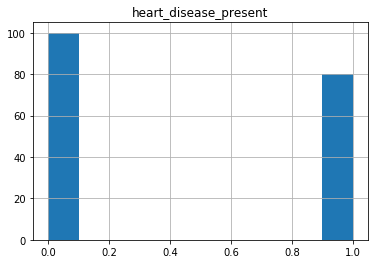

In [5]:
_ = train_labels.hist(figsize=(6, 4))

## Targets are mostly balanced
Not unreasonable to treat these as balanced. Given more time it might be a good idea try oversampling points from the positive set using [`imbalanced-learn`](https://imbalanced-learn.org/en/stable/index.html).

# Let's take a look at the distributions of the input features

In [6]:
train_values.sample(10)

,slope_of_peak_exercise_st_segment,thal,resting_blood_pressure,chest_pain_type,num_major_vessels,fasting_blood_sugar_gt_120_mg_per_dl,resting_ekg_results,serum_cholesterol_mg_per_dl,oldpeak_eq_st_depression,sex,age,max_heart_rate_achieved,exercise_induced_angina
patient_id,,,,,,,,,,,,,
qvhk9e,1,normal,120,3,0,0,0,215,0.0,0,37,170,0
mcwqgs,2,reversible_defect,120,3,3,0,0,188,2.0,1,49,139,0
v52zcs,2,reversible_defect,128,4,2,0,2,259,3.0,1,58,130,1
gla0im,2,normal,120,3,0,0,2,211,1.5,0,68,115,0
h3uzv8,1,normal,155,3,0,0,0,269,0.8,0,65,148,0
hfp05i,1,normal,118,3,3,0,2,149,0.8,1,49,126,0
27oevk,1,normal,130,4,0,0,2,330,0.0,0,61,169,0
pjgqa3,1,normal,122,4,0,0,2,222,0.0,1,48,186,0
ewckbx,2,reversible_defect,130,4,2,0,2,206,2.4,1,60,132,1


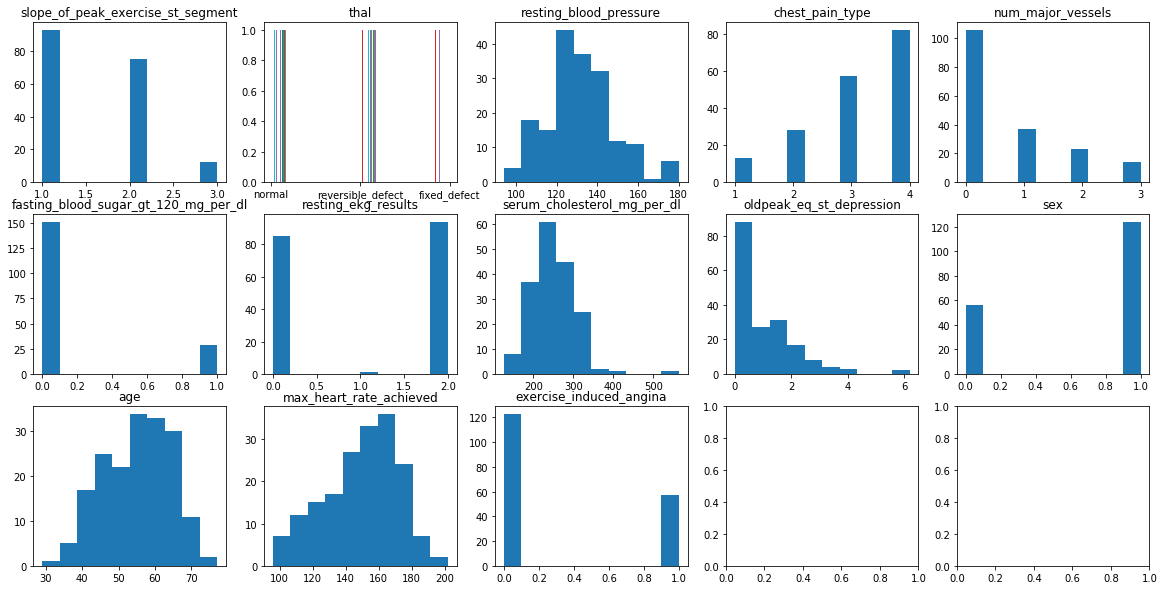

In [7]:
n_features = len(train_values.columns)
n_cols = 5
n_rows = ceil(n_features / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))

for i, column in enumerate(train_values):
    ax = axs[divmod(i, n_cols)]
    _ = ax.hist(train_values[column])
    _ = ax.set_title(column)

# A variety of distributions
## A mixture of continuous, ordinal, and categorical

I'll one-hot-encode the boolean and categorical variables:
- Boolean: fasting_blood_sugar_gt_120_mg_per_dl, exercise_induced_angina
- Categorical: chest_pain_type, sex

and leave the others as they are:
- Continuous: resting_blood_pressure, serum_cholesterol_mg_per_dl, oldpeak_eq_st_depression, age, max_heart_rate_achieved
- Ordinal: slope_of_peak_exercise_st_segment, num_major_vessels, resting_ekg_results

## Treat all continuous variables as coming from a normal distribution
Most of the features seem close enough to normally distributed. Of course things like age, max_heart_rate are bounded at zero, but the data appear just about normally distributed, so I won't do any transformations on them.

In [8]:
preprocessors = build_features.build_preprocessors(train_values)
train_features = build_features.preprocess_data(train_values, preprocessors)

/home/robert/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/robert/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/robert/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/robert/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/robert/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input 

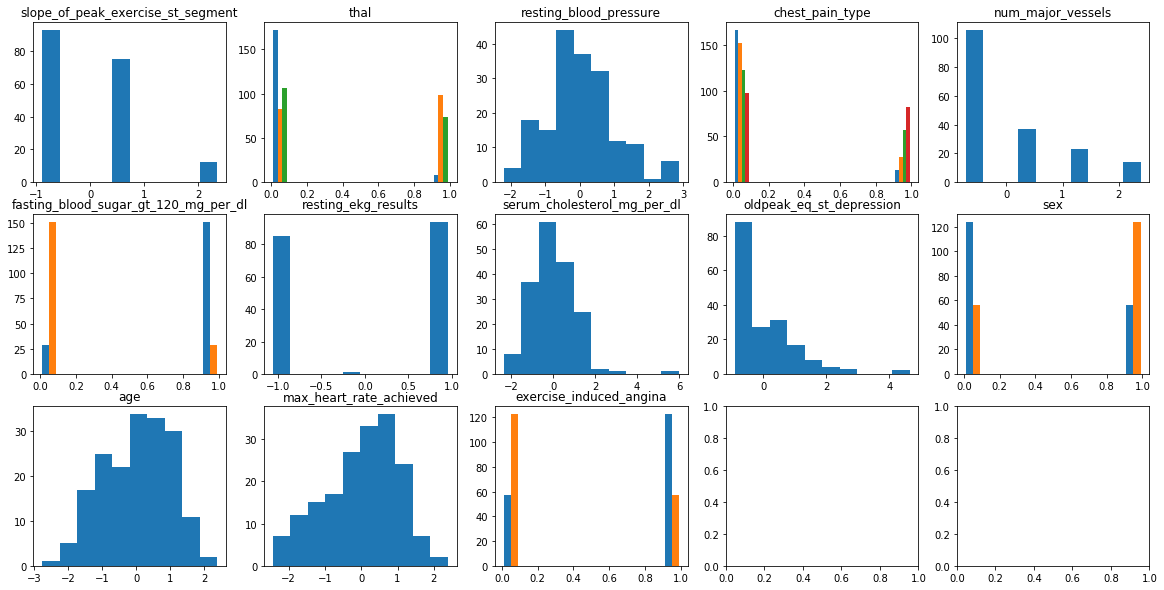

In [9]:
n_features = len(train_features)
n_cols = 5
n_rows = ceil(n_features / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 10))

for i, (name, values) in enumerate(zip(train_values, train_features)):
    ax = axs[divmod(i, n_cols)]
    _ = ax.hist(values)
    _ = ax.set_title(name)

# Create array of training data
Preprocessing like one-hot encoding makes several conceptually related variables out of one variable (e.g., `chest_pain_type` becomes four different variables). I refer to the multiple conceptually related variables as a *feature space*. To keep track of which feature space each column belongs to, I'll use a class called ``ConcatenateFeatures`` that converts between lists of feature spaces (which are useful for interpretation) and a concatenated feature array (which we actually fit).

In [10]:
concatenator = build_features.ConcatenateFeatures()

_ = concatenator.fit(train_features, names=train_values.columns)
X = concatenator.transform(train_features)

# Fit the model
I'll model the presence of heart disease using regularized logistic regression. Logistic regression can model linear relationships between input variables and output classes. I expect this to perform pretty well as a first pass. A benefit is that we can easily interpret the weights of a logistic regression model -- positive weights show variables that increase the likelihood of heart disease and negative weights show variables that decrease the likelihood of heart disease.



In [11]:
Cs = np.logspace(-3, 5, 20)
logistic_regression = linear_model.LogisticRegressionCV(Cs=Cs, cv=5, solver='lbfgs')

In [12]:
_ = logistic_regression.fit(X, train_labels.values.ravel())

## Hyperparameter selection
Just out of curiosity, let's look at the performance at different levels of regularization. Small values of $C$ strongly penalize weights, and large values do not penalize weights much. There seems to be a clear peak at intermediate values. It's a little bit of evidence that cross-validating this parameter gains us a small performance boost.

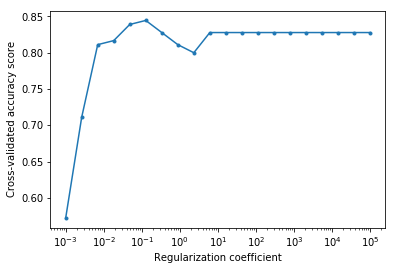

In [17]:
_ = plt.semilogx(logistic_regression.Cs, logistic_regression.scores_[1].mean(0), '.-')
_ = plt.xlabel('Regularization coefficient')
_ = plt.ylabel('Cross-validated accuracy score')

### Model interpretation
With linear regression, we can interpret the weights to mean how much a certain factor increases or decreases the probability of having heart disease. We can conclude that having a reversible defect and high number of major vesselss increase the risk relative to the average person in the dataset.

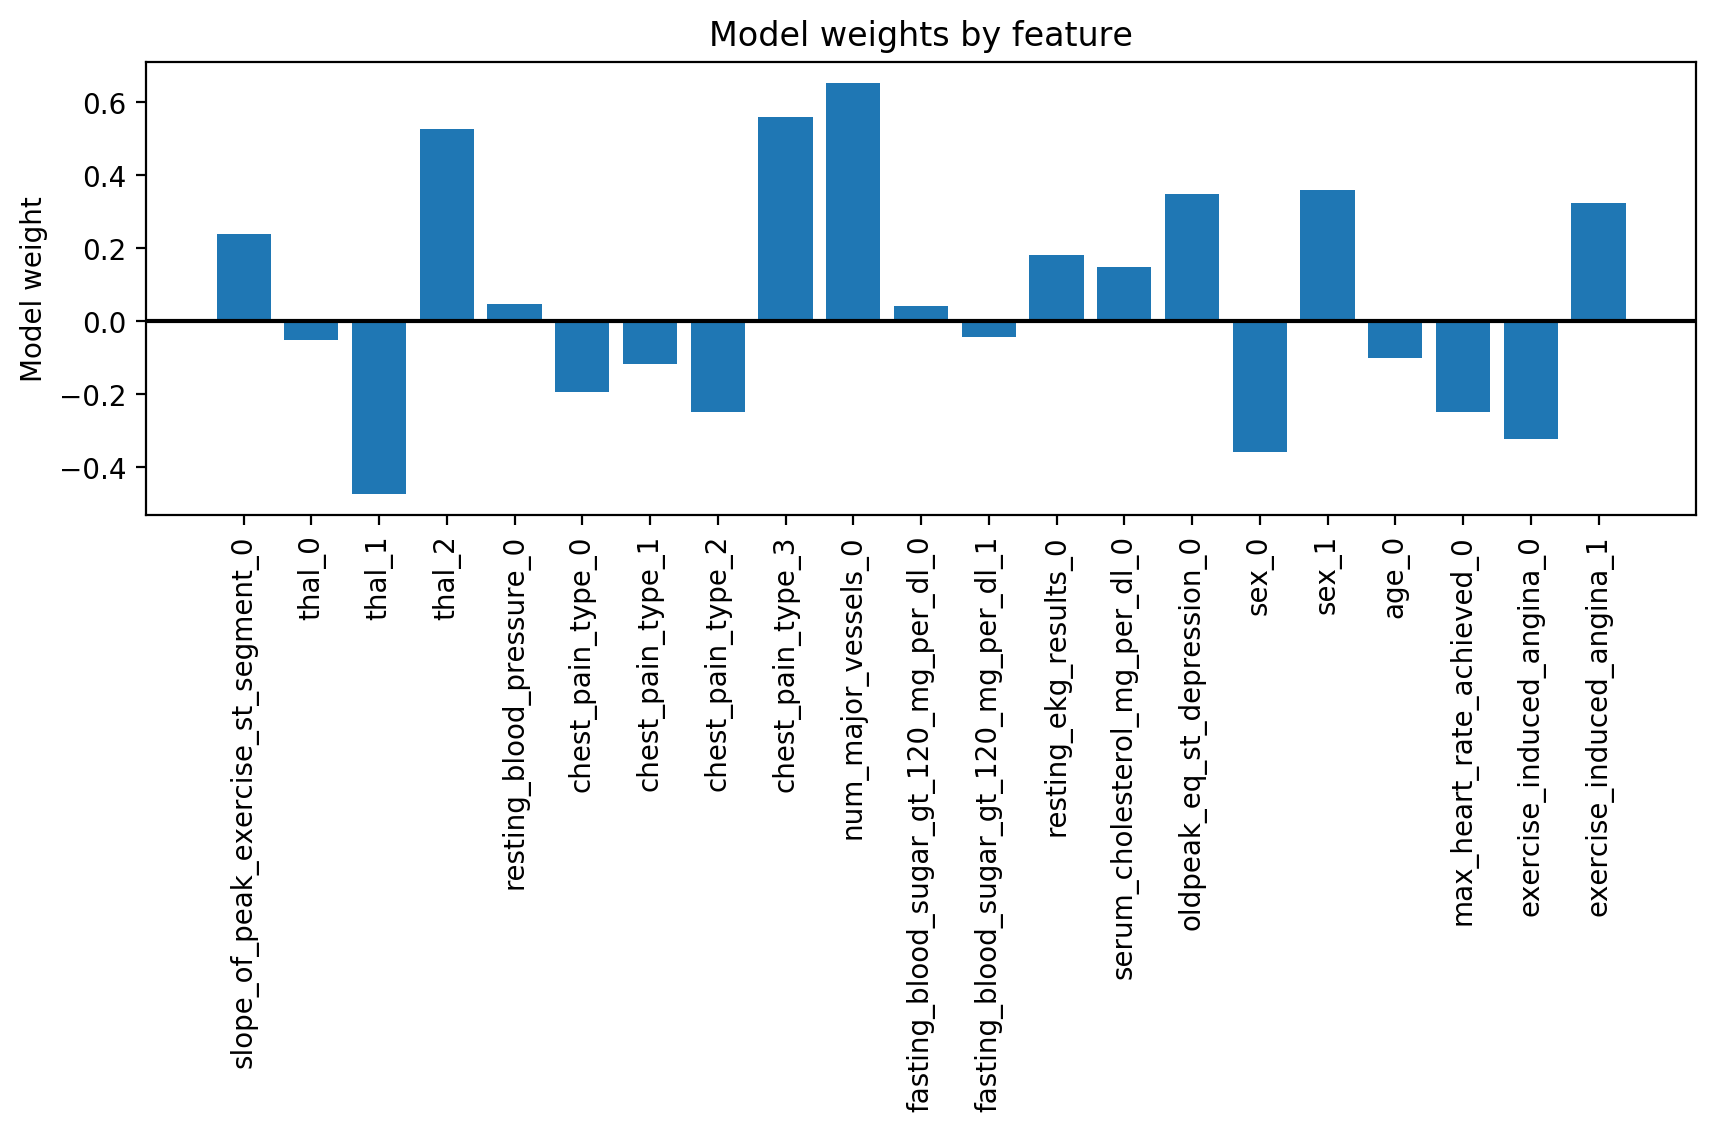

In [19]:
x_position = np.arange(logistic_regression.coef_.shape[1])

fig = plt.figure(figsize=(10, 3), dpi=200)
_ = plt.bar(x_position, logistic_regression.coef_.ravel(),)
_ = plt.xticks(x_position, concatenator._feature_names, rotation=90)
_ = plt.axhline(0, color='black')
_ = plt.ylabel('Model weight')
_ = plt.title('Model weights by feature')

In [20]:
feature_names = ['thal', 'chest_pain_type', 'sex']
for feature_name in feature_names:
    categories = preprocessors[feature_name].steps[0][1].categories_[0]
    for index, name in enumerate(categories):
        print(f"{feature_name}_{index}:\t{name}")

thal_0:	fixed_defect
thal_1:	normal
thal_2:	reversible_defect
chest_pain_type_0:	1
chest_pain_type_1:	2
chest_pain_type_2:	3
chest_pain_type_3:	4
sex_0:	0
sex_1:	1
